### Урок3. Связь бизнес-показателей и DS-метрик

План занятия:
0. Ликбез: train/test/val и crossvalidation
1. переход от вероятностей к меткам в задаче бинарной классификации
2. какие бывают DS-метрики, их интерпретация
3. пример из практики
4. бизнес-метрики
5. взаимосвязь DS и бизнес метрик
6. case1 - фильтрация токсичных комментариев
7. case2 - определение ССЗ 

### Разбивка на train/test/val

![ab_split](Sets.png "Tr_Test_val")

#### Вопрос 1: в чем назначение каждого из набора данных?

### Кроссвалидация (CV)

![ab_split](cv.png "CV")

### Задача бинарной классификации

![ab_split](binary_clf1.jpg "binary1")

Бинарный классификатор выдает нам "вероятности" (всегда ли?). Вроде 0.13, 0.87, etc

Однако нам от этого всего мало пользы и требуется в рамках практической задачи получить метки классов.

Например, в задаче оттока нам нужно отобрать подмножество пользователей, которые собираются уйти от нас для дальнейшей работы. 


Очевидное решение:
1. проскорить пользователей нашей моделью
2. отсортировать по убыванию "вероятности" (предсказаний нашей модели) - мы предполагаем, что чем больше "вероятность" ухода, тем более склонен конкретный пользователь уйти в отток
3. взять какой-то топ N пользователей получившегося списка

<b>Вопрос: какой N должен быть?</b>

<b>И еще вопрос: почему мы не можем взять тупо весь список?</b>

Выгода для клиента часто может быть невыгодна для сервиса/компании/оператора связи/etc (вернемся к этому немного позже)

### Задача бинарной классификации

Проиллюстрируем на примере

![ab_split](binary_clf2.jpg "binary2")

На практике чаще все не так идеально:

![ab_split](binary_clf3.png "binary3")

Пусть классификатор выдаёт метку класса. 

Обозначения: 
* yi – метка i-го объекта, 
* ai – ответ на конкретном объекте нашего алгоритма (предсказание), 
* m – число объектов в выборке

Самым простым и распространённым функционалом качества является точность (Accuracy или Mean Consequential Error):

![ab_split](accuracy.png "accuracy")

## Функции стоимости

Аппроксимация функции стоимости L(y!=y_true) в непрерывной форме для формирования оценки параметров w. 

In [1]:
import seaborn

# необходимые пакеты
import matplotlib.pyplot as plt
import numpy as np

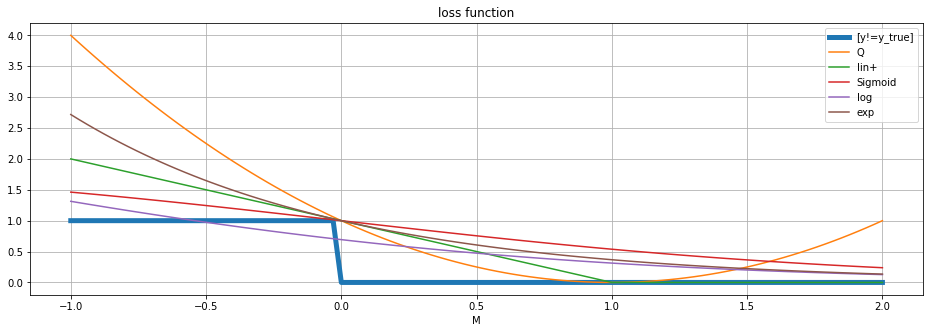

In [2]:

M= np.linspace(-1,2,100)

P=(M<0).astype(int)
Q=(1-M)**2
Li=(1-M)
Li[np.where(Li<0)[0]]=0

S=2*(1+np.exp(M)) ** (-1)

Lo = np.log(1+np.exp(-M))
E= np.exp(-M)
plt.figure(figsize=(16,5))
plt.plot(M,P, label='[y!=y_true]',linewidth=5)
plt.plot(M,Q, label='Q')
plt.plot(M,Li, label='lin+')
plt.plot(M,S, label='Sigmoid')
plt.plot(M,Lo, label='log')
plt.plot(M,E, label='exp')
plt.title('loss function')
plt.xlabel('M')
plt.grid()
plt.legend()
plt.show()

<b>Вопрос: в чем проблема такой метрики?</b>

<b>В каком случае она может быть использована?</b>

Т.е это просто доля (процент) объектов, на которых алгоритм выдал правильные ответы. Недостаток такого функционала понятен: он плохо справляется в случае дисбаланса классов, когда представителей одного из классов существенно больше, чем второго. В этом случае, с точки зрения точности, выгодно почти всегда выдавать метку самого популярного класса. Это может не согласовываться с логикой использования решения задачи. Например, в задаче детектирования редкого заболевания алгоритм, который всех относит к классу «здоровые», бесполезен.

Такая метрика нам не подходит (если выборка сбалансирована, то может и подойти), давайте двигаться далее

Рассмотрим такую штуку, как confusion_matrix

![ab_split](confusion_matrix.png "confusion_matrix")

Пример

![ab_split](conf_matrix.png "confusion_matrix")

Два класса делятся на положительный (обычно метка 1) и отрицательный (обычно метка 0 или –1). 

Объекты, которые алгоритм относит к положительному классу, называются положительными (Positive), те из них, которые на самом деле принадлежат к этому классу – истинно положительными (True Positive), остальные – ложно положительными (False Positive). Аналогичная терминология есть для отрицательного (Negative) класса. 

Дальше используем естественные сокращения:

* TP = True Positive,
* TN = True Negative,
* FP = False Positive,
* FN = False Negative.

![ab_split](accuracy2.png "accuracy2")

<b>Пример</b>

Допустим, мы хотим оценить работу системы, которая определяет токсичность комментариев. У нас есть 1000 обычных комментариев, 900 из которых наш бинарный классификатор определил верно как нормальные (True Negative = 900, False Positive = 100), и 50 токсичных комментариев, 25 из которых классификатор также определил верно (True Positive = 25, False Negative = 25).

Тогда accuracy получается таким:

In [3]:
accuracy = (250+900)/(900+100+250+250)
print(accuracy)

0.7666666666666667


А что если у нас тупой классификатор, который отвечает всегда, что комментарий не является токсичным?

In [4]:
accuracy = (1000)/(900+100+25+25)
print(accuracy)

0.9523809523809523


Видим, что accuracy выше, но нам явно такой классификатор не нужен

### Ошибки первого и второго рода

Ошибки классификатора делятся на две группы: первого и второго рода. 

В идеале (когда точность равна 100%) матрица несоответствий диагональная, ошибки вызывают отличие от нуля двух недиагональных элементов:

ошибка 1 рода (Type I Error) случается, когда объект ошибочно относится к положительному классу (= FP/m).


ошибка 2 рода (Type II Error) случается, когда объект ошибочно относится к отрицательному классу (= FN/m).

<b>Вопрос: являются ли эти ошибки равнозначными? В каких случаях да, а в каких нет? Приведите примеры</b>

### Другие метрики качества бинарной классификации

Раз уж мы разобрались с тем, что ошибки на разных классах имеют разный вес в рамках конкретной прикладной задачи, давайте введем метрики качества отдельно для классов

![ab_split](pr_rec.png "PRRecall")

Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.

![ab_split](pr_rec2.png "PRRecall2")

Вернемся к примеру с токсичными сообщениями

Допустим, мы хотим оценить работу системы, которая определяет токсичность комментариев. У нас есть 1000 обычных комментариев, 900 из которых наш бинарный классификатор определил верно как нормальные (True Negative = 900, False Positive = 100), и 50 токсичных комментариев, 25 из которых классификатор также определил верно (True Positive = 25, False Negative = 25).

In [5]:
precision = 25/(25+100)
recall = 25/(25+25)
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

Precision: 0.2
Recall: 0.5


<b>Вопрос: что мы можем сделать с прогнозами классификатора, чтобы поменять эти значения?</b>

<b>Бонусный вопрос: что будет с precision, если порог классификации выбрать равным 0? А с recall?</b>

<b>Пример</b>

In [6]:
import pandas as pd

df = pd.DataFrame({'y_true': [0,1,1,0,1,0,0,0,0,1], 
              'y_score': [0.1, 0.98, 0.52, 0.2, 0.41, 0.21, 0.95, 0.14, 0.01, 0.16]})
df

,y_true,y_score
0,0,0.10
1,1,0.98
2,1,0.52
3,0,0.20
4,1,0.41
5,0,0.21
6,0,0.95
7,0,0.14
8,0,0.01
9,1,0.16


Отсортируем по y_score

In [7]:
df = df.sort_values(by='y_score', ascending=False)
df

,y_true,y_score
1,1,0.98
6,0,0.95
2,1,0.52
4,1,0.41
5,0,0.21
3,0,0.20
9,1,0.16
7,0,0.14
0,0,0.10
8,0,0.01


У нас всего 10 объектов, из которых 4 относятся к классу "1" и 6 - к классу "0"

Для того, чтобы перейти от "вероятностей" (y_score) к меткам, выберем порог. Начнем с 0.5

In [8]:
th = 0.5
df['y_score_class'] = df['y_score'].apply(lambda x: 1 if x>=th else 0, 1)
df

,y_true,y_score,y_score_class
1,1,0.98,1
6,0,0.95,1
2,1,0.52,1
4,1,0.41,0
5,0,0.21,0
3,0,0.20,0
9,1,0.16,0
7,0,0.14,0
0,0,0.10,0
8,0,0.01,0


In [9]:
tp = 2
fp = 1
tn = 5
fn = 2

precison = tp/(tp+fp)
recall = tp/(tp+fn)
print("Precision: {}".format(precison))
print("Recall: {}".format(recall))

Precision: 0.6666666666666666
Recall: 0.5


Попробуем другой порог - 0.4

In [10]:
th = 0.4
df['y_score_class'] = df['y_score'].apply(lambda x: 1 if x>=th else 0, 1)
df

,y_true,y_score,y_score_class
1,1,0.98,1
6,0,0.95,1
2,1,0.52,1
4,1,0.41,1
5,0,0.21,0
3,0,0.20,0
9,1,0.16,0
7,0,0.14,0
0,0,0.10,0
8,0,0.01,0


In [11]:
tp = 3
fp = 1
tn = 5
fn = 1

precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

Precision: 0.75
Recall: 0.75


А что если понизить порог до 0.15

In [12]:
th = 0.15
df['y_score_class'] = df['y_score'].apply(lambda x: 1 if x>=th else 0, 1)
df

,y_true,y_score,y_score_class
1,1,0.98,1
6,0,0.95,1
2,1,0.52,1
4,1,0.41,1
5,0,0.21,1
3,0,0.20,1
9,1,0.16,1
7,0,0.14,0
0,0,0.10,0
8,0,0.01,0


In [13]:
tp = 4
fp = 3
tn = 3
fn = 0

precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

Precision: 0.5714285714285714
Recall: 1.0


### Переходим к f-score

Существует несколько различных способов объединить precision и recall в агрегированный критерий качества. 

F-score — среднее гармоническое precision и recall (обычно):

![ab_split](f_score1.png "F-score")

F-score достигает максимума при полноте и точности, равными единице, и близка к нулю, если один из аргументов близок к нулю.

In [14]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

precision, recall, thresholds = precision_recall_curve(df['y_true'], df['y_score'])
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.410000, F-Score=0.750, Precision=0.750, Recall=0.750


В sklearn много всего удобного уже есть, чем можно пользоваться, не изобретая велосипед

### Метрики качества, для которых не нужно подбирать порог

### ROC AUC

![ab_split](tpr_fpr.png "roc auc1")

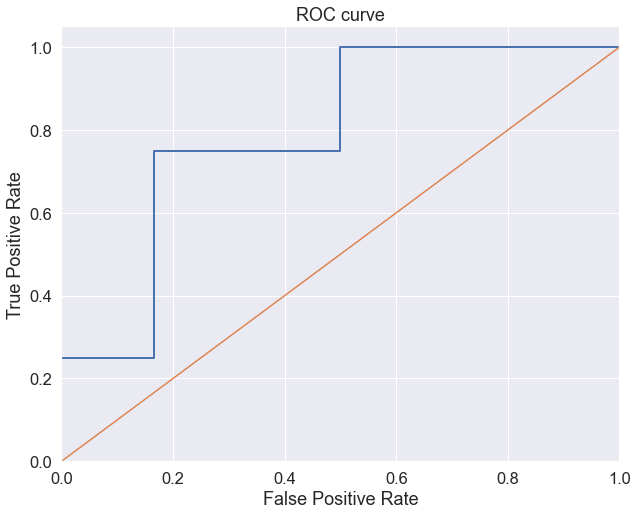

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(df['y_true'], df['y_score'], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [16]:
df

,y_true,y_score,y_score_class
1,1,0.98,1
6,0,0.95,1
2,1,0.52,1
4,1,0.41,1
5,0,0.21,1
3,0,0.20,1
9,1,0.16,1
7,0,0.14,0
0,0,0.10,0
8,0,0.01,0


In [17]:
roc_auc_score(df['y_true'], df['y_score'])

0.7916666666666667

<b>Вопрос: какой roc auc у случайного классификатора?</b>

In [18]:
roc_auc_score(df.sample(frac=1)['y_true'], df.sample(frac=1)['y_score'])

0.2916666666666667

<b>Вопрос: что делать, если roc auc меньше 0.5?</b>

Выглядит она не очень, но это только из-за того, что у нас мало данных

Как вообще строится этот график?

In [19]:
df[['y_true', 'y_score']]

,y_true,y_score
1,1,0.98
6,0,0.95
2,1,0.52
4,1,0.41
5,0,0.21
3,0,0.20
9,1,0.16
7,0,0.14
0,0,0.10
8,0,0.01


Чем хороша данная метрика?

1. часто используют для оценивания качества упорядочивания алгоритмом объектов двух классов
2. показывает долю правильно упорядоченных пар
3. может быть интерпретирован как вероятность того, что случайно выбранный positive объект будет проранжирован классификатором выше (будет иметь более высокую вероятность быть positive), чем случайно выбранный negative объект

Регрессии

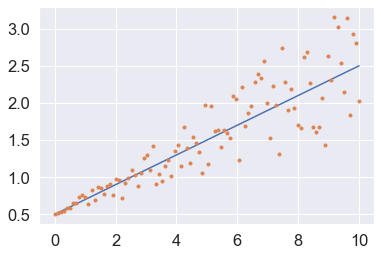

In [20]:
noise = 0.1

x = np.linspace(0,10,100).reshape(-1,1)
y = x*0.2 + 0.5
y_n = y + (np.random.rand((100)).reshape(-1,1)*noise*2-noise)*x

plt.plot(x,y)
plt.plot(x,y_n,'.')
plt.show()





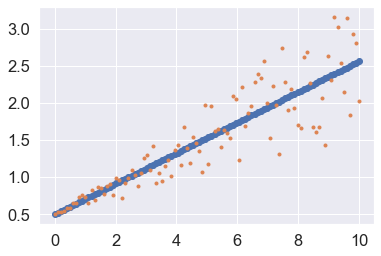

mse : 0.10152418593415781
r2:  0.7805783291318154
MAPE (Mean absolute percentage error) : 14.049347407970068


In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,  mean_squared_error


lr = LinearRegression().fit(x,y_n)



y_p = lr.predict(x)

plt.plot(x,y_p,'o')
plt.plot(x,y_n,'.')
plt.show()

print('mse :', mean_squared_error(y_n,y_p) )

print('r2: ',r2_score(y_n,y_p))


print('MAPE (Mean absolute percentage error) :', np.mean(np.abs(y_n-y_p)/np.abs(y_n))*100 )


### ПЕРЕРЫВ до 21:13

### Кейс 1 - фильтрация токсичных комментариев

Есть сервис, где люди могут оставлять комментарии

При этом часть комментариев является токсичной, т.е содержит расистские, сексистские и тому подобные вещи.

Над проверкой сообщений работают модераторы и мы хотим уменьшить на них нагрузку с помощью ML.

Вспомним первое занятие и сформулируем гипотезу

#### Гипотеза 1.
Мы предполагаем, что автоматическая фильтрация токсичных комментариев снизит нагрузку на модераторов и повысит их пропускную способность на 10%, при этом доля FP не превысит 10%

![ab_split](diag1.jpg "diag1")

In [22]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train = pd.read_csv('train.csv').fillna(' ').sample(frac=1)
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
9440,1909ee84327be70b,Bishonen: Sorry but this is just more of the s...,0,0,0,0,0,0
65729,afcd3962006ac040,"""\n\n US-centric \n\nThe layout of this articl...",0,0,0,0,0,0
127570,aa47b54d152a432e,Would you please cite the links you are talkin...,0,0,0,0,0,0


Здесь много разных вариантов, но мы сведем все к бинарному классу - toxic/nontoxic

In [23]:
train['y'] = train[class_names].max(axis=1).values
train['y'].value_counts()

0    143346
1     16225
Name: y, dtype: int64

Сделаем тренировочную и тестовую выборки

In [24]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(train.drop('y', 1), 
                                                    train['y'], random_state=0)

Посмотрим на распределение классов в выборках

In [25]:
y_train.value_counts(normalize=True)

0    0.898302
1    0.101698
Name: y, dtype: float64

In [26]:
y_test.value_counts(normalize=True)

0    0.898378
1    0.101622
Name: y, dtype: float64

Построим простое векторное представление текстов и обучим логистическую регрессию

In [27]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

classifier = Pipeline([('comment_text_selector', FeatureSelector(column='comment_text')), 
                     ('comment_text_tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            stop_words='english',
                                                            ngram_range=(1, 1),
                                                            max_features=100)), 
                     ('clf', LogisticRegression(C=0.1, solver='sag'))])

#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=3, scoring='roc_auc')
cv_score = np.mean(cv_scores)
print('CV score is {}'.format(cv_score))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.8023125917128141


Воспользуемся доступным в sklearn инструментарием, чтобы получить оптимальный порог

In [28]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

b=2.55

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.082630, F-Score=0.576, Precision=0.195, Recall=0.825


Нарисуем roc кривую

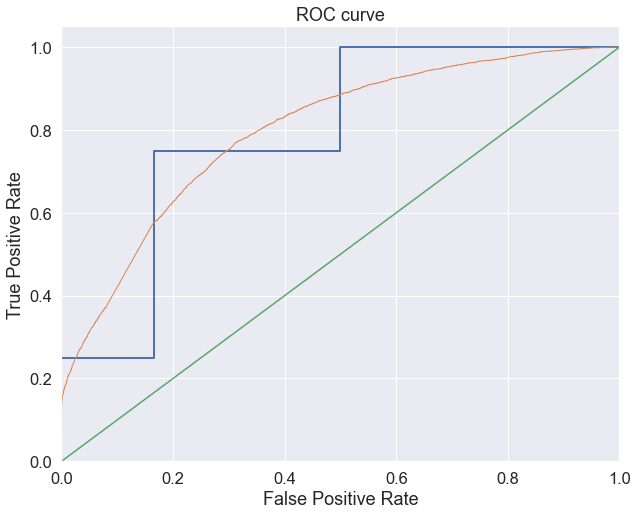

In [29]:
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr1, tpr1, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot(fpr1, tpr1, lw=1, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

Как это интерпетировать? Давайте построим матрицу ошибок, чтобы стало понятнее

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[22022 13817]
 [  711  3343]]


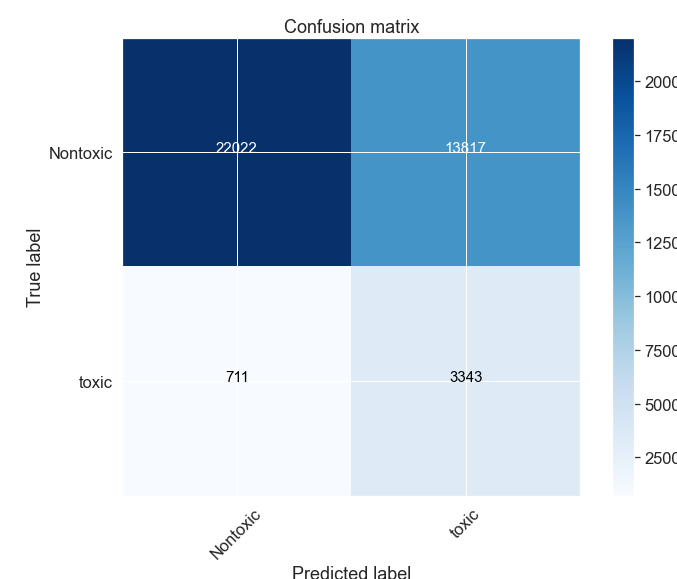

In [31]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Nontoxic', 'toxic'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [32]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

Посчитаем нужные нам метрики

In [33]:
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8246176615688209, 0.38552973018220377, 0.6144702698177963)

False Positive Rate всего лишь 0.096.

Это означает, что только 9.6 процентов всех комментариев будут помечены как токсичные некорректно

Вывод:

Мы можем автоматически фильтровать 88 процентов токсичных комментариев! Однако есть еще TPR

Глобальные выводы:

1. TNR = 0.9 -> модель может автоматически фильтровать 90% токсичных комментариев
2. TPR = 0.88 -> доля ошибочно классифицированных как токсичных (хотя это нормальные комментарии), не будет превышать при этом 9.6 процентов

Что дальше? - планируем эксперимент!

### Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [34]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [35]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [36]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [37]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [94]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from pprint import pprint
from copy import deepcopy

In [104]:
model = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42))
    ])


#запустим кросс-валидацию
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(cv_scores)
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
model.fit(X_train, y_train)
y_score = model.predict_proba(X_test)[:, 1]




[0.78781568 0.78373449 0.7924307  0.778893   0.78937801]
CV score is 0.7864503780644487+-0.00470508979002898


In [79]:
cv_scores['test_roc_auc']

array([0.78781568, 0.78373449, 0.7924307 , 0.778893  , 0.78937801])

In [77]:
import sklearn.metrics as mts
mts.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

Посчитаем precision/recall/f_score

In [39]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

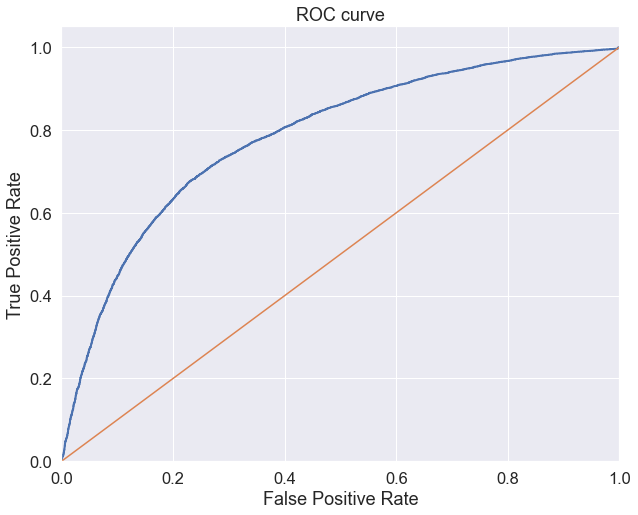

In [40]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [41]:
from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230668


Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


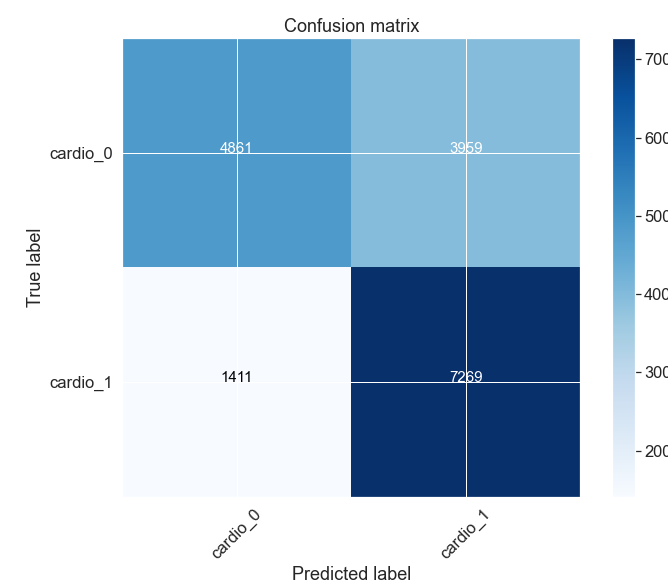

In [42]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

business_threshold = 1  # подберем порог для улучшения бизнесс показателя

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix]*business_threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [43]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

Хорошая ли модель у нас получилась? - ответ сильно зависит от внешних факторов (какое количество FP мы можем допустить)

#### Пусть:
 - стоимость лечения 15000 р, если сделали тест и начали лечить вовремя
 - стоимость лечения 20000, если упустили и начали лечить когда уже проявились все симптомы 
 - стоимость теста 1400 р
 
 
 
 - лишних тестов сделали FP = cnf_matrix[0][1]
 - пропустили больных FN = cnf_matrix[1][0]
 - правильных тестов сделали TP = cnf_matrix[1][1]

Оценим расходы, если не делать тест и ждать симптомов:

In [44]:
rubl_to_test = 1400
rubl_to_early_treatment = 15000
rubl_to_late_treatment = 20000

In [45]:
rubl_1 = (cnf_matrix[1][0]+cnf_matrix[1][1]) * rubl_to_late_treatment
print('расходы, если не делать тест и ждать симптомов:',rubl_1)

расходы, если не делать тест и ждать симптомов: 173600000


Расходы, если сделать тест всем:


In [46]:
rubl_all_test = np.sum(cnf_matrix) * rubl_to_test + (cnf_matrix[1][0]+cnf_matrix[1][1]) * rubl_to_early_treatment
print('расходы, если делать тест всем и лечить группу большых:',rubl_all_test)

расходы, если делать тест всем и лечить группу большых: 154700000


Расходы если использовать ML:

In [47]:
rubl_ML = (cnf_matrix[0][1]+cnf_matrix[1][1]) * rubl_to_test + (cnf_matrix[1][0]) * rubl_to_late_treatment + np.sum(cnf_matrix[1][1]) * rubl_to_early_treatment
print('расходы, если не делать тест и ждать симптомов:',rubl_ML)

расходы, если не делать тест и ждать симптомов: 152974200


Оценим разницу:


In [48]:
print(' Расходы при решении не делать тесты - расходы с МL :',rubl_1 - rubl_ML )
print(' Расходы при решении не делать тесты - расходы ссделать тесты всем  :',rubl_1 - rubl_all_test )
print(' Расходы сделать тесты всем - решение делать тесты ML  :',rubl_all_test - rubl_ML )

 Расходы при решении не делать тесты - расходы с МL : 20625800
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 1725800


Метрика по деньгам : получить меньше расходов чем при полном тесте

Расходы на тестирование всех и лечение при ранней диагностике - расходы на ML тест и лечение при ранней диагностике группы TP и поздней диагностике группы FN

In [49]:
def business_threshold_calibrate(y_test, y_score, thresholds,rubl_to_test = 100, rubl_to_early_treatment = 100, rubl_to_late_treatment = 1000):
    business_threshold = 0
    r1_r2_ = 0
    r1_r3_ = 0
    r2_r3_ = 0
    rubl_1_ = - 10000000 
    rubl_all_test_ = - 10000000 
    rubl_ML_ = - 10000000 

    r2 = []
    n = 10
    for opt_buisness_tr in np.linspace(0,1,n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > ( opt_buisness_tr))
        #print(cnf_matrix )
        rubl_1 = ((cnf_matrix[1][1]+cnf_matrix[1][0])) * rubl_to_late_treatment

        rubl_all_test = np.sum(cnf_matrix) * rubl_to_test + ((cnf_matrix[1][0]+cnf_matrix[1][1])) * rubl_to_early_treatment

        rubl_ML = ((cnf_matrix[1][1]+cnf_matrix[0][1])) * rubl_to_test + np.sum(cnf_matrix[1][0]) * rubl_to_late_treatment + (cnf_matrix[1][1]) * rubl_to_early_treatment
       
        r2_r3 = rubl_all_test - rubl_ML 
        
        r1_r2 = rubl_1 - rubl_all_test
        r1_r3 = rubl_1 - rubl_ML
        #print(opt_buisness_tr, r2_r3)
        if (r2_r3_ < r2_r3):
            
            business_threshold = opt_buisness_tr
            r1_r2_ = r1_r2
            r1_r3_ = r1_r3
            r2_r3_ = r2_r3
            rubl_1_ = rubl_1
            rubl_all_test_ = rubl_all_test
            rubl_ML_ = rubl_ML
            
        r2.append(r2_r3)   
            
    
    print('расходы, если не делать тест и ждать симптомов:',rubl_1_)
    print('расходы, если делать тест всем и лечить группу большых:',rubl_all_test_)
    print('расходы, если не делать тест и ждать симптомов:',rubl_ML_)
    print(' Расходы при решении не делать тесты - расходы с МL :',r1_r3_ )
    print(' Расходы при решении не делать тесты - расходы ссделать тесты всем  :',r1_r2_ )
    print(' Расходы сделать тесты всем - решение делать тесты ML  :',r2_r3_ )
    plt.plot(np.linspace(0,1,n),r2)
    plt.show()
    return business_threshold
    

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, если не делать тест и ждать симптомов: 152672600
 Расходы при решении не делать тесты - расходы с МL : 20927400
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 2027400


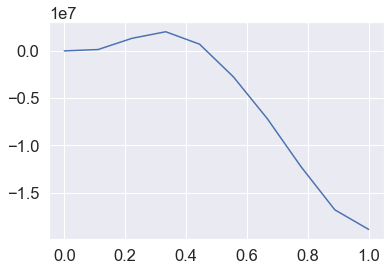

уровень порога по бизнес метрике 0.3333333333333333
уровень порога по f1 метрике 0.38693708911473795


In [50]:
BUisnes_tr = business_threshold_calibrate(y_test, y_score, 
                                          thresholds[ix] ,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',thresholds[ix])

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

### Ссылки

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [165]:
logres = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])
forest = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])
boosting = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

models = logres, forest, boosting

metrics = list()
for model in models:
    #запустим кросс-валидацию
    cv_scores = cross_validate(model, X_train, y_train, cv=10, scoring=('roc_auc', 'precision', 'recall', 'f1'), n_jobs=-1)
    for key in cv_scores:
        cv_scores[key] = (round(cv_scores[key].mean(), 5), round(cv_scores[key].std(), 5))
    cv_scores.pop('fit_time')
    cv_scores.pop('score_time')
    metrics.append(cv_scores)
pprint(metrics)

[{'test_f1': (0.71087, 0.00617),
  'test_precision': (0.74609, 0.00593),
  'test_recall': (0.67885, 0.00796),
  'test_roc_auc': (0.78667, 0.00653)},
 {'test_f1': (0.70989, 0.00524),
  'test_precision': (0.71998, 0.00449),
  'test_recall': (0.7001, 0.00734),
  'test_roc_auc': (0.77466, 0.0042)},
 {'test_f1': (0.72503, 0.00571),
  'test_precision': (0.75552, 0.00615),
  'test_recall': (0.69695, 0.00781),
  'test_roc_auc': (0.80237, 0.00583)}]


In [166]:
mtrcs = ("test_f1", 'test_precision', 'test_recall', 'test_roc_auc')
models = ('logreg', 'forest', 'boosting')
        
for i, model in enumerate(metrics):
    print(models[i], end='\n')
    for mtrc in mtrcs:
        print(f'{mtrc} = {model[mtrc][0]:6}+-{model[mtrc][1]:6}', end='\t')
    print('\n')

logreg
test_f1 = 0.71087+-0.00617	test_precision = 0.74609+-0.00593	test_recall = 0.67885+-0.00796	test_roc_auc = 0.78667+-0.00653	

forest
test_f1 = 0.70989+-0.00524	test_precision = 0.71998+-0.00449	test_recall = 0.7001+-0.00734	test_roc_auc = 0.77466+-0.0042	

boosting
test_f1 = 0.72503+-0.00571	test_precision = 0.75552+-0.00615	test_recall = 0.69695+-0.00781	test_roc_auc = 0.80237+-0.00583	



Лучше всего справился бустинг, но мы не проводили особых настроек, модели были из коробки.

Для дисбалансных классов лучше подходит precision_recall_curve так как, при ее построении видно наличие проблемы, если мы будем ошибаться в малочисленном классе. ROC кривая покажет весьма приличные резултаты.